In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import sys

sys.path.append(os.path.dirname(os.getcwd()))

import torch
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import balanced_accuracy_score, accuracy_score,confusion_matrix
from transformers import BertTokenizer
from data.dataloader import build_train_test_dataset
import tqdm
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "/home/kuhaku/Code/EmotionClassification/code/3m-ser-private/scripts/checkpoints/3M-SER-Layernorm/20230607-101548/weights/best_acc/checkpoint_0.pt"
model = torch.load(model_path, map_location=device)
test_file = open("../../scripts/data/test_data.pkl", "rb")
test_list = pickle.load(test_file)
# Multi-modal prediction

sprectromes = []
texts = []
y_actu=[]
y_pred=[]
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model.to(device)
model.eval()
for every_test_list in tqdm.tqdm(test_list):
    label1=every_test_list['label']

    label1=torch.tensor([label1])
    label1 = label1.to(device)
    sprectrome = every_test_list['sprectrome']
    sprectrome = sprectrome.to(device)
    text=every_test_list['text']
    texts.append(text)
    sprectromes.append(sprectrome)
    input_ids = torch.tensor(tokenizer.encode(text, add_special_tokens=True)).unsqueeze(0)
    input_ids = input_ids.to(device)
    with torch.no_grad():
      if(sprectrome.shape[2]>65):
        output = model(input_ids,sprectrome)
        _, preds = torch.max(output, 1)
        y_actu.append(label1.cpu().numpy()[0])
        y_pred.append(preds.cpu().numpy()[0])
accuracy_score(y_actu, y_pred)

100%|██████████| 933/933 [00:46<00:00, 20.12it/s]


0.7995712754555199

In [12]:
y_n_pred = np.array(y_pred)
y_n_actu = np.array(y_actu)
false = np.where(y_n_pred != y_n_actu)[0]

In [13]:
import csv
with open("false_case.csv", 'w') as f:
  csvwriter = csv.writer(f) 
  csvwriter.writerow(["Actual", "Pred", "Text"])
  
  cls_name = ["Anger", "Happiness", "Sadness", "Neutral"]
  for index in false:
    csvwriter.writerow([cls_name[y_n_actu[index]], cls_name[y_n_pred[index]], texts[index]])

[[153   6   2  16]
 [  9 237   6  29]
 [  5   5 169  25]
 [ 21  43  20 187]]


ValueError: 'spectral' is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'

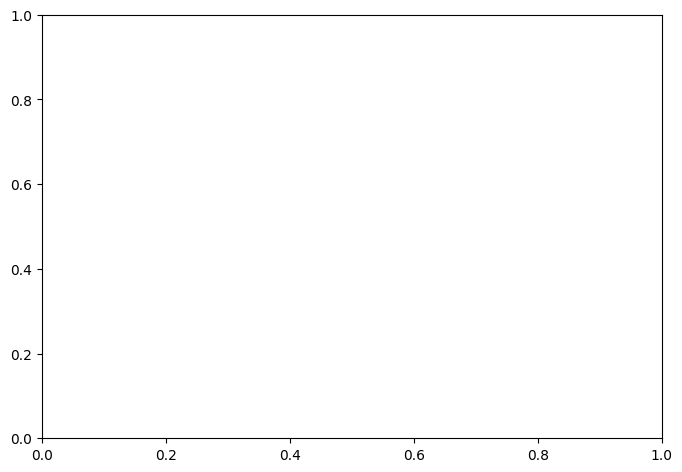

In [3]:
cm = confusion_matrix(y_actu, y_pred)
print(cm)
cmn = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])*100

# 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'

ax = plt.subplots(figsize=(8, 5.5))[1]
sns.heatmap(cmn, cmap='YlOrBr', annot=True, square=True, linecolor='black', linewidths=0.75, ax = ax, fmt = '.2f', annot_kws={'size': 16})
ax.set_xlabel('Predicted', fontsize=18, fontweight='bold')
ax.xaxis.set_label_position('bottom')
ax.xaxis.set_ticklabels(["Anger", "Happiness", "Sadness", "Neutral"], fontsize=16)
ax.set_ylabel('Ground Truth', fontsize=18, fontweight='bold')
ax.yaxis.set_ticklabels(["Anger", "Happiness", "Sadness", "Neutral"], fontsize=16)
plt.tight_layout()
plt.savefig('WithLayernorm.png', format='png', dpi=1200)
plt.show()

In [15]:
wa = balanced_accuracy_score(y_actu, y_pred)
ua = accuracy_score(y_actu, y_pred)
print("Weighted Accuracy: ", wa)
print("Unweighted Accuracy: ", ua)

Weighted Accuracy:  0.8065728556714504
Unweighted Accuracy:  0.7995712754555199
